**IMPORT LIBRARIES**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
!pip install silence_tensorflow
import silence_tensorflow.auto

import tensorflow as tf
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras import regularizers, activations
from tensorflow.keras import initializers as init
from tensorflow.keras import optimizers as opti
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout

import keras
from keras.models import Sequential
from keras.layers import Dense

import sklearn as sk
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, validation_curve 
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error as mse_fn
from sklearn.model_selection import KFold

  Created wheel for silence-tensorflow: filename=silence_tensorflow-1.1.1-cp36-none-any.whl size=3743 sha256=87e57aab055f0fb8ff37fd0c6ba6e41689ea0cd92e5a54fb2960714615c1079c
  Stored in directory: /root/.cache/pip/wheels/51/0b/35/cf3020764bee61daa81fa249df3a448e3806344a087fc12292
Successfully built silence-tensorflow


**DATA PREPROCESSING**

In [2]:
# load data and figure out essential columns

data = pd.read_csv('Churn_Modelling.csv')
print("Number of columns:", len(data.keys()))
print("Column header:", list(data.keys()))

Number of columns: 14
Column header: ['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


In [3]:
# Input - columns 3 to 12
# Output - column 13

x = data.iloc[:, 3:13].values
y = data.iloc[:, 13].values
df = pd.DataFrame((np.c_[x[:10], y[:10]]))
head = list(data.keys())[3:13]
head.append('Output')
df.columns = head
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Output
0,619,France,Female,42,2,0,1,1,1,101349,1
1,608,Spain,Female,41,1,83807.9,1,0,1,112543,0
2,502,France,Female,42,8,159661,3,1,0,113932,1
3,699,France,Female,39,1,0,2,0,0,93826.6,0
4,850,Spain,Female,43,2,125511,1,1,1,79084.1,0
5,645,Spain,Male,44,8,113756,2,1,0,149757,1
6,822,France,Male,50,7,0,2,1,1,10062.8,0
7,376,Germany,Female,29,4,115047,4,1,0,119347,1
8,501,France,Male,44,4,142051,2,0,1,74940.5,0
9,684,France,Male,27,2,134604,1,1,1,71725.7,0


In [4]:
# Encode countries in 0,1,2
# Encode gender in 0,1

x[:, 1] = LabelEncoder().fit_transform(x[:, 1])
x[:, 2] = LabelEncoder().fit_transform(x[:, 2])
df = pd.DataFrame((np.c_[x[:10], y[:10]]))
head = list(data.keys())[3:13]
head.append('Output')
df.columns = head
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Output
0,619,0,0,42,2,0,1,1,1,101349,1
1,608,2,0,41,1,83807.9,1,0,1,112543,0
2,502,0,0,42,8,159661,3,1,0,113932,1
3,699,0,0,39,1,0,2,0,0,93826.6,0
4,850,2,0,43,2,125511,1,1,1,79084.1,0
5,645,2,1,44,8,113756,2,1,0,149757,1
6,822,0,1,50,7,0,2,1,1,10062.8,0
7,376,1,0,29,4,115047,4,1,0,119347,1
8,501,0,1,44,4,142051,2,0,1,74940.5,0
9,684,0,1,27,2,134604,1,1,1,71725.7,0


In [5]:
# One hot encoding for Geography (column 1-3), Gender (column 4-5), HasCrCard (column 6-7), IsActiveMember (column 8-9)
# remaining features in other columns in same order

ct = ColumnTransformer([("Geography", OneHotEncoder(), [1]),
                        ("Gender", OneHotEncoder(), [2]),
                        ("HasCrCard", OneHotEncoder(), [7]),
                        ("IsActiveMember", OneHotEncoder(), [8])], remainder = 'passthrough')
x = ct.fit_transform(x)
print("Number of columns after one hot encoding:", len(x[0]))

Number of columns after one hot encoding: 15


**TRAIN TEST SPLIT**

In [6]:
x_train, x_test, y_train, y_test = [np.asarray(data).astype(np.float32) for data in train_test_split(x, y, test_size = 0.2, random_state = 1, shuffle = 1)]
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (8000, 15)
y_train shape: (8000,)
x_test shape: (2000, 15)
y_test shape: (2000,)


In [7]:
# Normalize the data

norm = StandardScaler()
x_train = norm.fit_transform(x_train)
x_test = norm.transform(x_test)

**THE MODEL**

In [11]:
# Input parameters: 

# input dimension (number of features)
# hidden and output layer dimensions
# activation at each layer
# weight initialisation 
# optimizer
# batch normalise (none, before activation or after activation)
# dropout rate (none or a value for each layer)
# epochs
# batch size
# x_train, y_train, x_test, y_test

def build(input_dim = 15, dims = [12,12,1], act = ['relu', 'relu', 'sigmoid'], 
          w_ini = 'uniform', opt = 'adam', batch_norm = None, dropout = None,
          epoch = 200, batch_size = 256, x = x_train, y = y_train, xt = x_test, yt = y_test):
  
  model = Sequential()
  model.add(keras.Input(shape=(input_dim,)))

  for i in range(len(dims)-1):
    
    if batch_norm == None:
      model.add(Dense(dims[i], act[i], 1, w_ini, w_ini))
      if dropout: 
        model.add(Dropout(dropout[i]))
    
    elif batch_norm == 'before':
      model.add(Dense(units = dims[i], kernel_initializer = w_ini, bias_initializer = w_ini))
      if dropout: 
        model.add(Dropout(dropout[i]))
      model.add(BatchNormalization())
      model.add(Activation(act[i]))
    
    else:
      model.add(Dense(units = dims[i], kernel_initializer = w_ini, bias_initializer = w_ini))
      if dropout: 
        model.add(Dropout(dropout[i]))
      model.add(Activation(act[i]))
      model.add(BatchNormalization())


  model.add(Dense(dims[-1], act[-1], 1, w_ini, w_ini))
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['binary_accuracy'])

  w_before = model.get_weights()
  history = model.fit(x, y, epochs=epoch, batch_size=batch_size, verbose=0, validation_data=(xt,yt))
  w_after = model.get_weights()

  return history, w_before, w_after

# **QUESTION 1 - WEIGHT INITIALISATION**

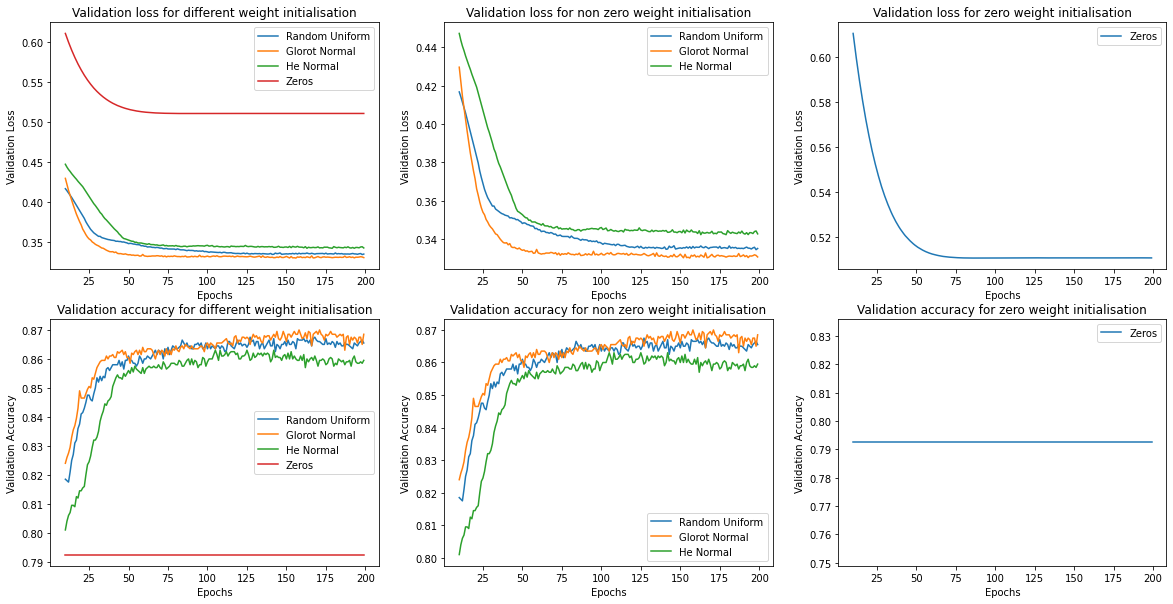

In [59]:
w_ini = [init.RandomUniform(-0.5,0.5), init.GlorotNormal(), init.HeNormal(), init.Zeros()]
labels = ['Random Uniform','Glorot Normal','He Normal','Zeros']

hist, w_before, w_after = {},{},{}

fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(20,10))
ax = axes.flatten()

for i in range(4):
  hist[i], w_before[i], w_after[i] = build(w_ini = w_ini[i])

  ax[0].plot(np.arange(10, 200), hist[i].history["val_loss"][10:], label = labels[i])
  ax[0].set(title = "Validation loss for different weight initialisation", xlabel = "Epochs", ylabel = "Validation Loss")
  ax[3].plot(np.arange(10, 200), hist[i].history["val_binary_accuracy"][10:], label = labels[i])
  ax[3].set(title = "Validation accuracy for different weight initialisation", xlabel = "Epochs", ylabel = "Validation Accuracy")
  
  if(i!=3):
    ax[1].plot(np.arange(10, 200), hist[i].history["val_loss"][10:], label = labels[i])
    ax[1].set(title = "Validation loss for non zero weight initialisation", xlabel = "Epochs", ylabel = "Validation Loss")
    ax[4].plot(np.arange(10, 200), hist[i].history["val_binary_accuracy"][10:], label = labels[i])
    ax[4].set(title = "Validation accuracy for non zero weight initialisation", xlabel = "Epochs", ylabel = "Validation Accuracy")
  else:
    ax[2].plot(np.arange(10, 200), hist[i].history["val_loss"][10:], label = labels[i])
    ax[2].set(title = "Validation loss for zero weight initialisation", xlabel = "Epochs", ylabel = "Validation Loss")
    ax[5].plot(np.arange(10, 200), hist[i].history["val_binary_accuracy"][10:], label = labels[i])
    ax[5].set(title = "Validation accuracy for zero weight initialisation", xlabel = "Epochs", ylabel = "Validation Accuracy")


ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[2].legend(loc='best')
ax[3].legend(loc='best')
ax[4].legend(loc='best')
ax[5].legend(loc='best')
fig.show()

**Observations:** 


1.   For all zeros initial weights:
 
   *   The validation loss remains higher than that for non zero weight initialisation even after all epochs.
   *   The model is not training effectively and accuracy remains almost same for all epochs because predictions after training at each epoch do not change significantly to cross the threshold and be classified as a different class.
   *   The accuracy close to 80% is because of the fact that the fact that dataset is skewed with most output labels as zero.
   *   Essentialy, here all nodes end up with same gradient change and hence same weights after every epoch so it will be no different that having just one node in the hidden layer. Weights moving together limit the power of back propagation to search the entire space to find the optimal weights which lower the loss.This is the Symmetry problem, that necessitates random weight initialisation.

2.   For non zero initial weights:

  *   The difference in training loss and accuracy here is almost negligible, which shows that the network is stable and can converge for any kind of non zero weight initialisation.





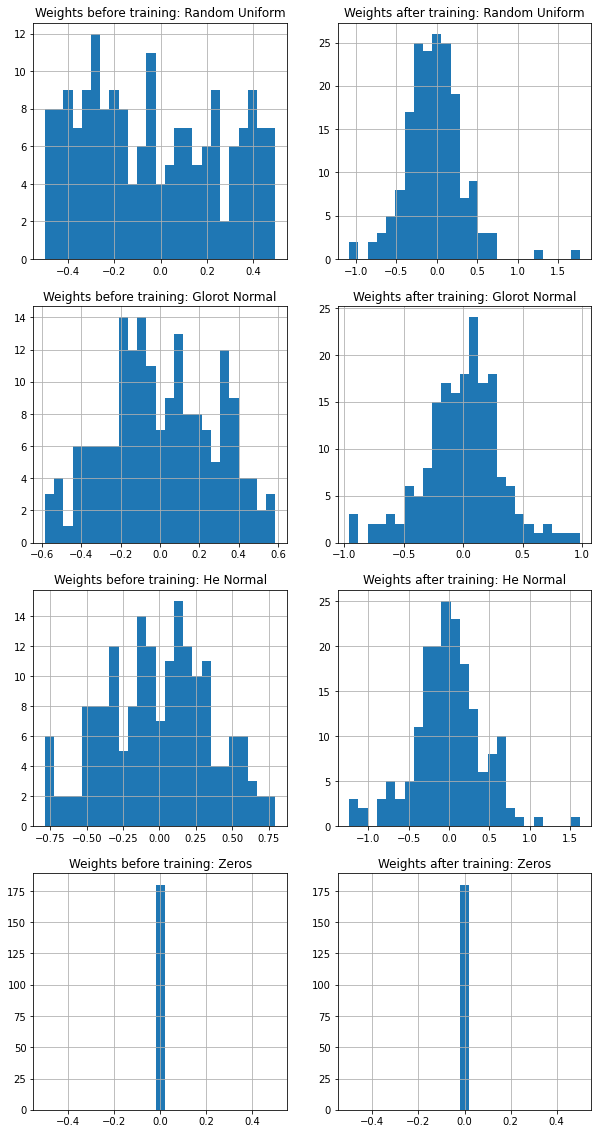

In [60]:
# weight histograms

bins = 25

k = 1
plt.figure(figsize=(10, 20))
for i in range(4):
  plt.subplot(4,2,k)
  plt.hist(w_before[i][0].flatten(),bins)
  plt.title('Weights before training: '+ labels[i]);plt.grid()
  plt.subplot(4,2,k+1)
  plt.hist(w_after[i][0].flatten(),bins)
  plt.title('Weights after training: ' + labels[i]);plt.grid()
  k = k + 2
plt.show()

**Observations:**

1.   Initialising the model with non zero weights from different distribution, after traning it converges to almost same distribution, close to gaussian distribution. This shows the neural network is stable.

2.   Initialising the model with all zero weight, it does not even train and classifies everything as zero. So the distribution of weight never changes.




# **QUESTION 2 - OPTIMIZERS**

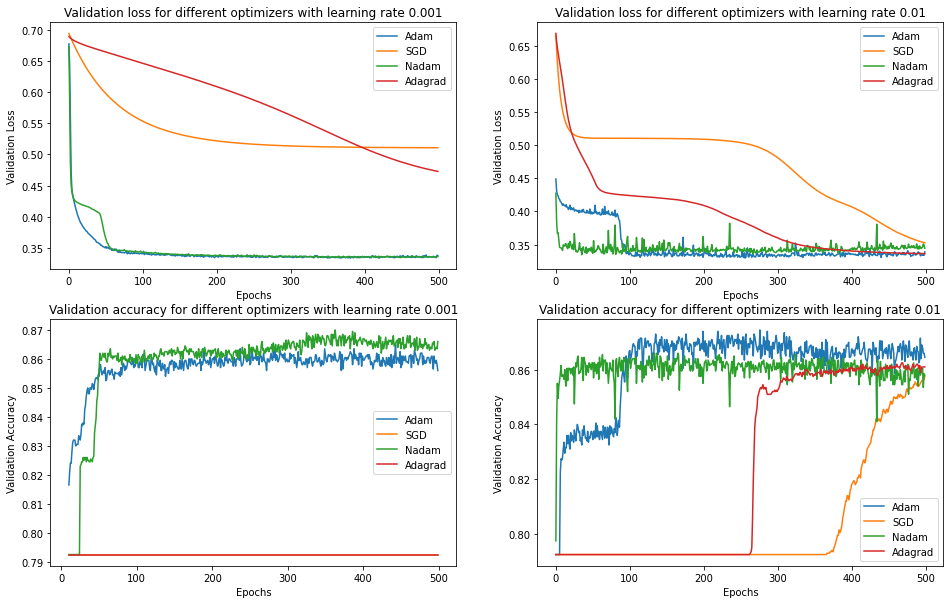

In [74]:
rate1 = 0.001
opt1 = [opti.Adam(rate1),opti.SGD(rate1),opti.Nadam(rate1),opti.Adagrad(rate1)]
rate2 = 0.01
opt2 = [opti.Adam(rate2),opti.SGD(rate2),opti.Nadam(rate2),opti.Adagrad(rate2)]
labels = ['Adam','SGD','Nadam','Adagrad']

hist1, hist2, wb, wa = {}, {}, {}, {}

fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(16,10))
ax = axes.flatten()

for i in range(4):
  
  hist1[i], wb[i], wa[i] = build(opt = opt1[i], epoch = 500)
  ax[0].plot(hist1[i].history["val_loss"], label = labels[i])
  ax[0].set(title = "Validation loss for different optimizers with learning rate 0.001", xlabel = "Epochs", ylabel = "Validation Loss")
  ax[2].plot(np.arange(10,500), hist1[i].history["val_binary_accuracy"][10:], label = labels[i])
  ax[2].set(title = "Validation accuracy for different optimizers with learning rate 0.001", xlabel = "Epochs", ylabel = "Validation Accuracy")
  
  hist2[i], wb[i], wa[i] = build(opt = opt2[i], epoch = 500)
  ax[1].plot(hist2[i].history["val_loss"], label = labels[i])
  ax[1].set(title = "Validation loss for different optimizers with learning rate 0.01", xlabel = "Epochs", ylabel = "Validation Loss")
  ax[3].plot(hist2[i].history["val_binary_accuracy"], label = labels[i])
  ax[3].set(title = "Validation accuracy for different optimizers with learning rate 0.01", xlabel = "Epochs", ylabel = "Validation Accuracy")


ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[2].legend(loc='best')
ax[3].legend(loc='best')
fig.show()

**Observations:**


1.   For small learning rates, ADAM and NADAM optimizers converge faster than SGD and Adagrad.
2.   For large learning rates, SGD and Adagrad converge smoothly, but here ADAM and NADAM may show diverging behaviour because it may skip the optimal point of convergence because of its speed.
3.   Due to sower convergence, SGD and Adagrda take time to reach good accuracy, espescilly in the small learning rate case where they train very very slowly showing negligible effect in accuracy foe hundreds of epochs. 



# **QUESTION 3 - BATCH NORMALISATION**

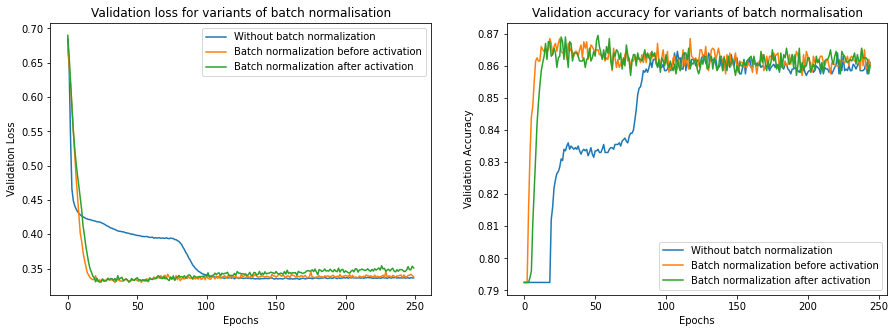

In [10]:
batch_norm = [None,'before','after']
labels = ['Without batch normalization','Batch normalization before activation','Batch normalization after activation']

hist, wb, wa = {}, {}, {}

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
ax = axes.flatten()

for i in range(3):
  
  hist[i], wb[i], wa[i] = build(batch_norm = batch_norm[i], epoch = 250)
  ax[0].plot(hist[i].history["val_loss"], label = labels[i])
  ax[0].set(title = "Validation loss for variants of batch normalisation", xlabel = "Epochs", ylabel = "Validation Loss")
  ax[1].plot(hist[i].history["val_binary_accuracy"][5:], label = labels[i])
  ax[1].set(title = "Validation accuracy for variants of batch normalisation", xlabel = "Epochs", ylabel = "Validation Accuracy")

ax[0].legend(loc='best')
ax[1].legend(loc='best')
fig.show()

**Observations:**

1.   Using batch normalization we get faster convergence and the learning process stabilizes in significantly lower number of training epochs. The accuracy also increases as compared to no batch normalisation.
2.   Although this dataset does not show significant changes in performance by applying batch normalisation before or after activation, generally applying batch norm after the activation yields better results because the batch norm layer can fully control the statistics of the input going into the next layer since its output do not have to pass through an activation. 



# **QUESTION 4 - DROPOUT**

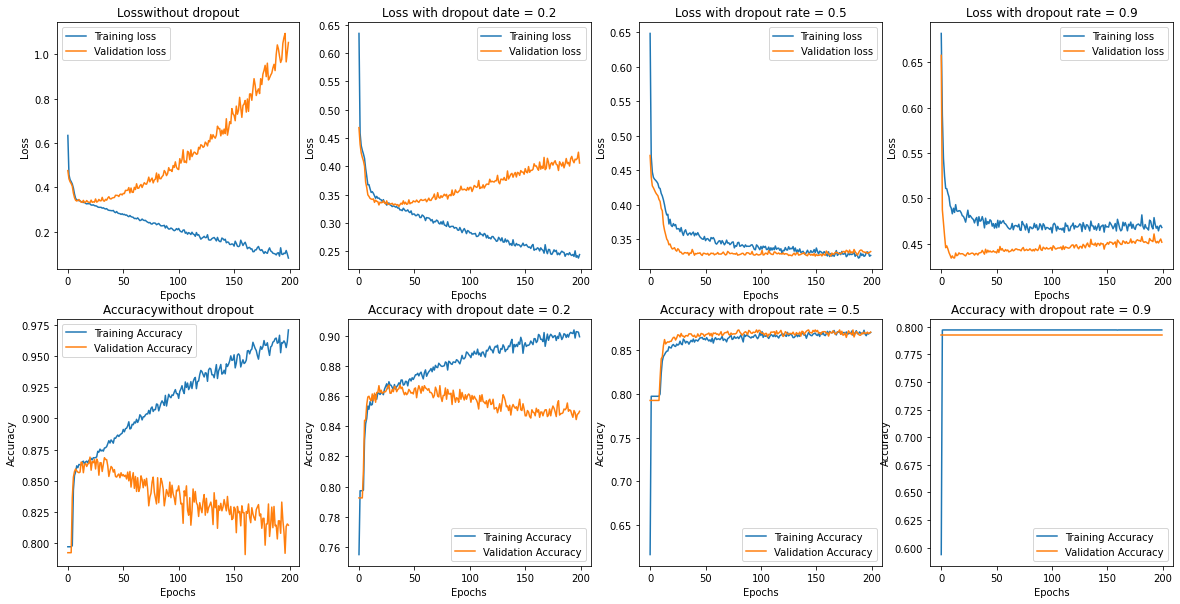

In [28]:
dims = [128]*2 + [64]*2 + [1]
act = ['relu']*4 + ['sigmoid']
drop = [None, [0.2]*4, [0.5]*4, [0.9]*4]
labels = ['without dropout','dropout date = 0.2','dropout rate = 0.5','dropout rate = 0.9']

hist, wb, wa = {}, {}, {}

fig, axes = plt.subplots(nrows=2, ncols=4,figsize=(20,10))
ax = axes.flatten()

for i in range(4):
  
  hist[i], wb[i], wa[i] = build(dims = dims, act = act, dropout = drop[i], epoch = 200)
  ax[i].plot(hist[i].history["loss"], label = "Training loss")
  ax[i].plot(hist[i].history["val_loss"], label = "Validation loss")
  ax[i].set(title = "Loss" + labels[i] if i==0 else "Loss with " + labels[i], xlabel = "Epochs", ylabel = "Loss")
  ax[i+4].plot(hist[i].history["binary_accuracy"], label = "Training Accuracy")
  ax[i+4].plot(hist[i].history["val_binary_accuracy"], label = "Validation Accuracy")
  ax[i+4].set(title = "Accuracy" + labels[i] if i==0 else "Accuracy with " + labels[i], xlabel = "Epochs", ylabel = "Accuracy")

ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[2].legend(loc='best')
ax[3].legend(loc='best')
ax[4].legend(loc='best')
ax[5].legend(loc='best')
ax[6].legend(loc='best')
ax[7].legend(loc='best')
fig.show()

**Observations:**

The model architecture is changed from two hidden layers with 12 nodes to 4 hidden layers with 128, 128, 64, 64 nodes each in order to amke it overfit.
1.   Without dropout, model will train well with very epoch but will loose ability to genarlize well on unseen data due to overfitting and hence difference between training loss - validation loss and training accuracy validation accuracy starts increasing after some point.
2.  With increasing dropout, this difference goes on dereasing upto certain optimal dropout rate (close to 0.5 here)
3.  With extremley large dropout, the model can not not learn at all i.e. it underfits and hence accuracy changes negligibly with epochs and validationloss converges to a higher value.



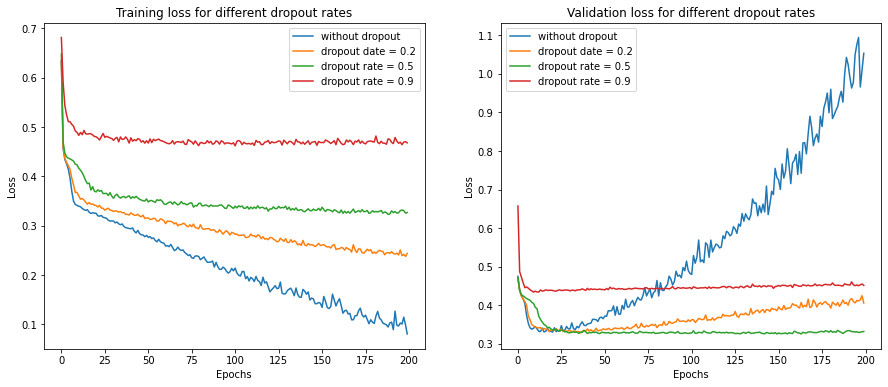

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,6))
ax = axes.flatten()

for i in range(4): 
  ax[0].plot(hist[i].history["loss"], label = labels[i])
  ax[0].set(title = "Training loss for different dropout rates", xlabel = "Epochs", ylabel = "Loss")
  ax[1].plot(hist[i].history["val_loss"], label = labels[i])
  ax[1].set(title = "Validation loss for different dropout rates", xlabel = "Epochs", ylabel = "Loss")

ax[0].legend(loc='best')
ax[1].legend(loc='best')
fig.show() 

**Observations:**

1.   As dropout increases, model trains less rigorously, hence converging to higher training loss value.
2.   The least validation loss is obtained for optimal dropout value. WIthout dropout, validation loss increases due to lack of generalisation of an overfit model on unseen data. For very low dropout, it still overfits and for very high droput it will underfits, so validation losses higher than that in case with optimal dropout.

